# Project 4 - Concrete Strength Prediction

### Objective:

To predict the concrete strength using the data available in file "concrete.csv". Apply feature engineering and model tuning to obtain a score above 85%.

In [1]:
from scipy import stats


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(color_codes=True)

from matplotlib.cbook import boxplot_stats

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import KFold, cross_val_score



import warnings 
warnings.filterwarnings('ignore')

In [2]:
#loading dataset into ABT table
ABT=pd.read_csv('concrete.csv')

In [3]:
#checking if the data has been loaded correctly and how table looks like
ABT.head(5)

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


## 1. Exploratory Data Quality Report

### 1.1 Data types and description of the independent attributes which should include (name, range of values observed, central values (mean and median), standard deviation and quartiles, analysis of the body of distributions/tails. (2 Marks)

In [4]:
ABT.shape

(1030, 9)

Dataframe is organized in 9 columns and 1030 rows.

In [5]:
ABT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


There are 8 indepednent attributes and one target varibale strength. All variables are of type float 64 bit, except age which is integer. 

In [6]:
ABT.describe().T

,count,mean,std,min,25%,50%,75%,max
cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
slag,1030.0,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4
ash,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1
water,1030.0,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0
superplastic,1030.0,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2
coarseagg,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0
fineagg,1030.0,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6
age,1030.0,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0
strength,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6


Measures of central tendency as well as measures of dispersions for given dataset can be easiley read (e.g. mean and median (50%) or standard deviation - std) or calculated (e.g. IQR=75%-25%, range=max-min) from the table above.
Wherever mean is greater than median we may suspect the data is right/positive skewed. Attributes like slag, ash and age show significantly larger mean compared to median. at least 50% of all values of ash is equal to 0., while for slag, percentage os such values is at least 25%, so those two attributes are highly right skewed.
Some of the attributes tends to have wide distribution (those with high coefficient of variation), e.g. ash or age, while some have narrower distribution - e.g. water, fineagg, coarseagg.
Age attribute, as expected, is of type integer and has range of 364 corresponding to 364 days. This is the only independent variable not comparable to the others due to unit of measurement. It is right skewed, with 50% of data is equal or less then 28 days.

### 1.2 Missing values analysis, Outlier detection, Duplicates check, Comment about if the zero values mean the null value here. (4 Marks)

#### Missing values

In [7]:
ABT.isnull().sum()

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

There are no null values in given dataset, however, since some variables shows high percentage of values equal to 0 (like slag, ash and superplastic), the validty of such statement had to be checked. According to information provided in Concrete_Readme.txt file on link https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/ ,under the Summary Statistics, it is stated there are none missing attribute values. Conclusion might be reached that zeros in this dataset are actual zeros and not null values.


#### Outliers

In [4]:
# detecting outliers using IQR
Q1=ABT.quantile(0.25)
Q3=ABT.quantile(0.75)
IQR=Q3-Q1
# number of outliers per column
ABT[~((ABT<Q1-1.5*IQR)|(ABT>Q3+1.5*IQR))].isna().sum()

cement           0
slag             2
ash              0
water            9
superplastic    10
coarseagg        0
fineagg          5
age             59
strength         4
dtype: int64

In [5]:
# number of rows without outliers 
ABT[~((ABT<Q1-1.5*IQR)|(ABT>Q3+1.5*IQR)).any(axis=1)].shape[0]

941

In [6]:
# detecting outliers using standard deviation
upper_boundary=ABT.mean()+3*ABT.std()
lower_boundary=ABT.mean()-3*ABT.std()

# number of outliers per column
ABT[~((ABT<lower_boundary)|(ABT>upper_boundary))].isna().sum()

cement           0
slag             4
ash              0
water            2
superplastic    10
coarseagg        0
fineagg          0
age             33
strength         0
dtype: int64

In [7]:
#number of rows without outliers
ABT[~((ABT<lower_boundary)|(ABT>upper_boundary)).any(axis=1)].shape[0]

981

Two methods of detecting outliers have been used in codes above to identify outlier - method using IQR and method using standard deviation.
Number of of outliers is greater when outliers are detected using IQR method (Q1-1.5*IQR and Q3+1.5*IQR) then when they are identified using three standard deviation method from the mean.

If we rule out outliers in the vicintiy of +/- 3sigma while using second method, the number of outliers remained unchanged (except for "water"). This method might be usefull for capping while dealing with outliers. The vicintiy of +/- 3sigma is taken arbitrary dividing std by 10. In this case such method would be useless.

In [8]:
#number of outliers 
ABT[~((ABT<(lower_boundary-ABT.std()/10))|(ABT>(upper_boundary+ABT.std()/10)))].isna().sum()

cement           0
slag             4
ash              0
water            0
superplastic    10
coarseagg        0
fineagg          0
age             33
strength         0
dtype: int64

In [9]:
#number of rows without outliers when 
#those in vicinity of +- 3 sigma from mean are outrulled
ABT[~((ABT<(lower_boundary-ABT.std()/10))|(ABT>(upper_boundary+ABT.std()/10))).any(axis=1)].shape[0]

983

#### Duplicates check

In [10]:
#number of duplicates in dataset
ABT.duplicated().sum()

25

In [11]:
#duplicated rows
ABT[ABT.duplicated()==True]

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
278,425.0,106.3,0.0,153.5,16.5,852.1,887.1,3,33.40
298,425.0,106.3,0.0,153.5,16.5,852.1,887.1,3,33.40
400,362.6,189.0,0.0,164.9,11.6,944.7,755.8,3,35.30
420,362.6,189.0,0.0,164.9,11.6,944.7,755.8,3,35.30
463,362.6,189.0,0.0,164.9,11.6,944.7,755.8,56,77.30
468,252.0,0.0,0.0,185.0,0.0,1111.0,784.0,28,19.69
482,425.0,106.3,0.0,153.5,16.5,852.1,887.1,91,65.20
493,362.6,189.0,0.0,164.9,11.6,944.7,755.8,91,79.30
517,425.0,106.3,0.0,153.5,16.5,852.1,887.1,56,64.30
525,362.6,189.0,0.0,164.9,11.6,944.7,755.8,28,71.30


In [12]:
#copying dataset to preserve original base table
dataset=ABT.copy()

In [13]:
#removing duplicates from dataset
dataset=dataset.drop_duplicates()
dataset.shape

(1005, 9)

There were total of 25 rows duplicated within given dataset. New dataset is generated and duplicates have been deleted.

#### Comment about if the zero values mean the null value

Please, refer to insight of missing values. 

In addition, simple search on web revealed that e.g. "...fly ash is used as a replacement for Portland cement in concrete" [1]. In such context, zero for fly ash is eligible value. The same applies for slag as well: 
"GGBS is used to make durable concrete structures in combination with ordinary Portland cement and/or other pozzolanic materials" [2].

[1] https://en.wikipedia.org/wiki/Fly_ash

[2] https://en.wikipedia.org/wiki/Ground_granulated_blast-furnace_slag

###  1.3 Using various plots, write the insights/observations about it. (6 Marks) 

In [14]:
#function that plots distribution plot and boxplot for given column as input
def plotting(column):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,2))
    sns.distplot(column, rug=True, ax=axs[0])
    sns.boxplot(column, ax=axs[1])
    plt.show()
    #printing outliers if identified via boxplot_stats
    if len(boxplot_stats(column).pop(0)['fliers'])!=0:
        print('Identified outliers are: ')
        print(boxplot_stats(column).pop(0)['fliers'])
        print('\n')

Plots for column cement:


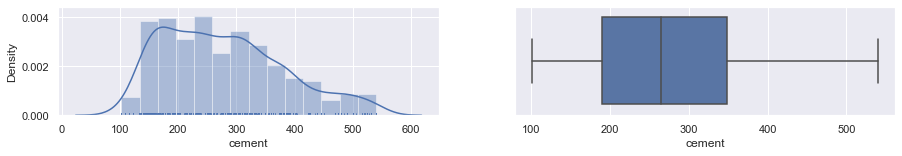

Plots for column slag:


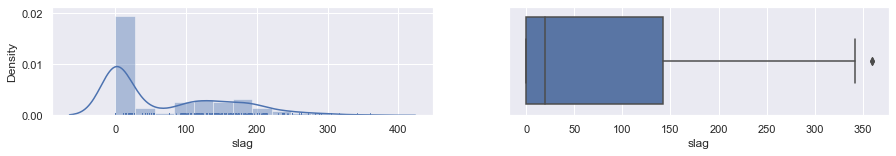

Identified outliers are: 
[359.4 359.4]


Plots for column ash:


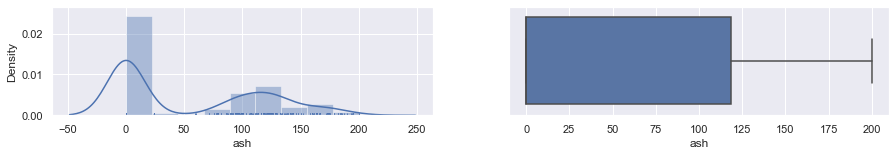

Plots for column water:


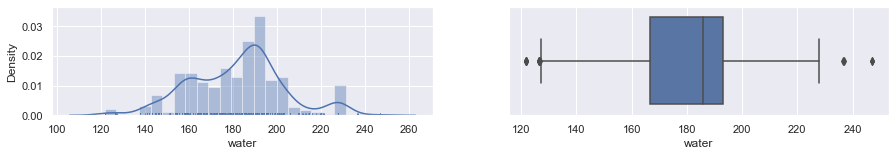

Identified outliers are: 
[127.  126.6 121.8 126.6 121.8 126.6 126.6 121.8 121.8 126.6 121.8 247.
 246.9 237.  236.7]


Plots for column superplastic:


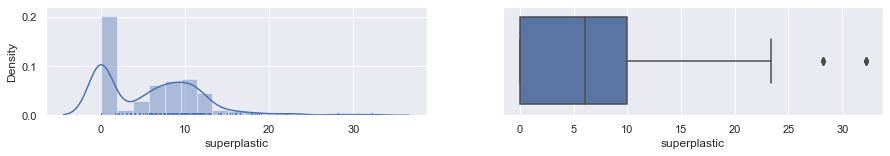

Identified outliers are: 
[28.2 28.2 32.2 32.2 28.2 32.2 32.2 28.2 32.2 28.2]


Plots for column coarseagg:


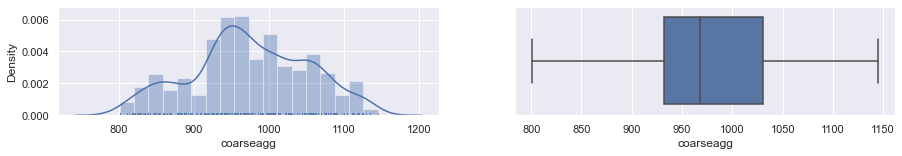

Plots for column fineagg:


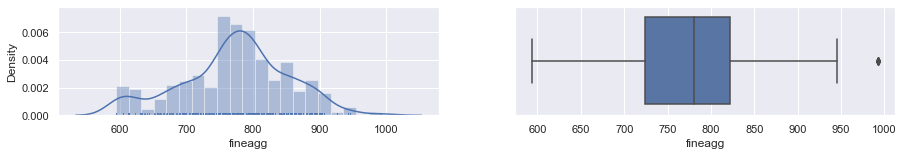

Identified outliers are: 
[992.6 992.6 992.6 992.6 992.6]


Plots for column age:


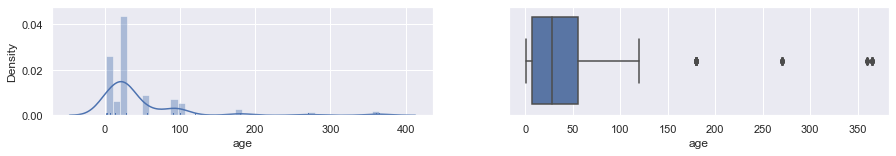

Identified outliers are: 
[180 365 180 180 180 365 180 270 180 360 365 365 180 180 270 270 270 270
 180 180 270 360 180 360 180 365 360 365 365 180 270 180 180 365 180 180
 270 270 180 180 365 365 180 365 360 180 270 180 270 180 365 360 270 365
 180 180 365 180 270]


Plots for column strength:


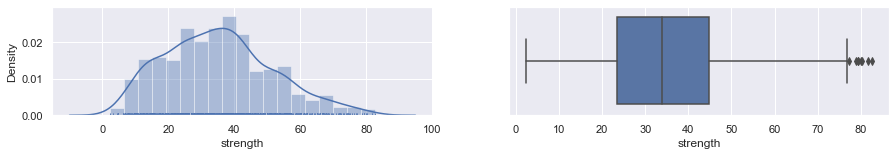

Identified outliers are: 
[77.3  81.75 79.3  79.4  78.8  79.99 82.6  80.2 ]




In [15]:
#plotting plots for all attributes in dataset
for i in dataset.columns:
    print('Plots for column {}:'.format(i))
    plotting(dataset[i])

Attribute "cement" is slightly right skewed. Attribute "slag" looks like there are two gaussians present, one around zero, the other around value of 150. The same applies for attribute "ash" with slightly less center value for second gaussian. Relationships with target variable might reveal there are actual two gaussians in this dataset, however, no conclusion can be made at this stage. Attribute "water" is slightly left/negative skewed having most of the outliers below Q1-1.5* IQR. Attribute "superplastic" shows similar properties like "slag" and "ash", with one distinction - it has significantly lower size of magnitude compared to others. Courseagg and fineagg are in highes magnitude compared to other materials used for production of concrete. In addition, fineagg have symetrical distribution with some outliers in higher end. Column age has the highest number of outliers. It might be worth of trying to make it as categorical variable with bucketed data with equal distribution of data in each bucket, having the having the last bucket containing all data above certain level.
Finally distribution of the target variable strength shows some weight on the left side, however, it is suffering from some outliers in the higher end. 

##  2. Bi-variate analysis between the predictor variables and also between the predictor variables and target column. 

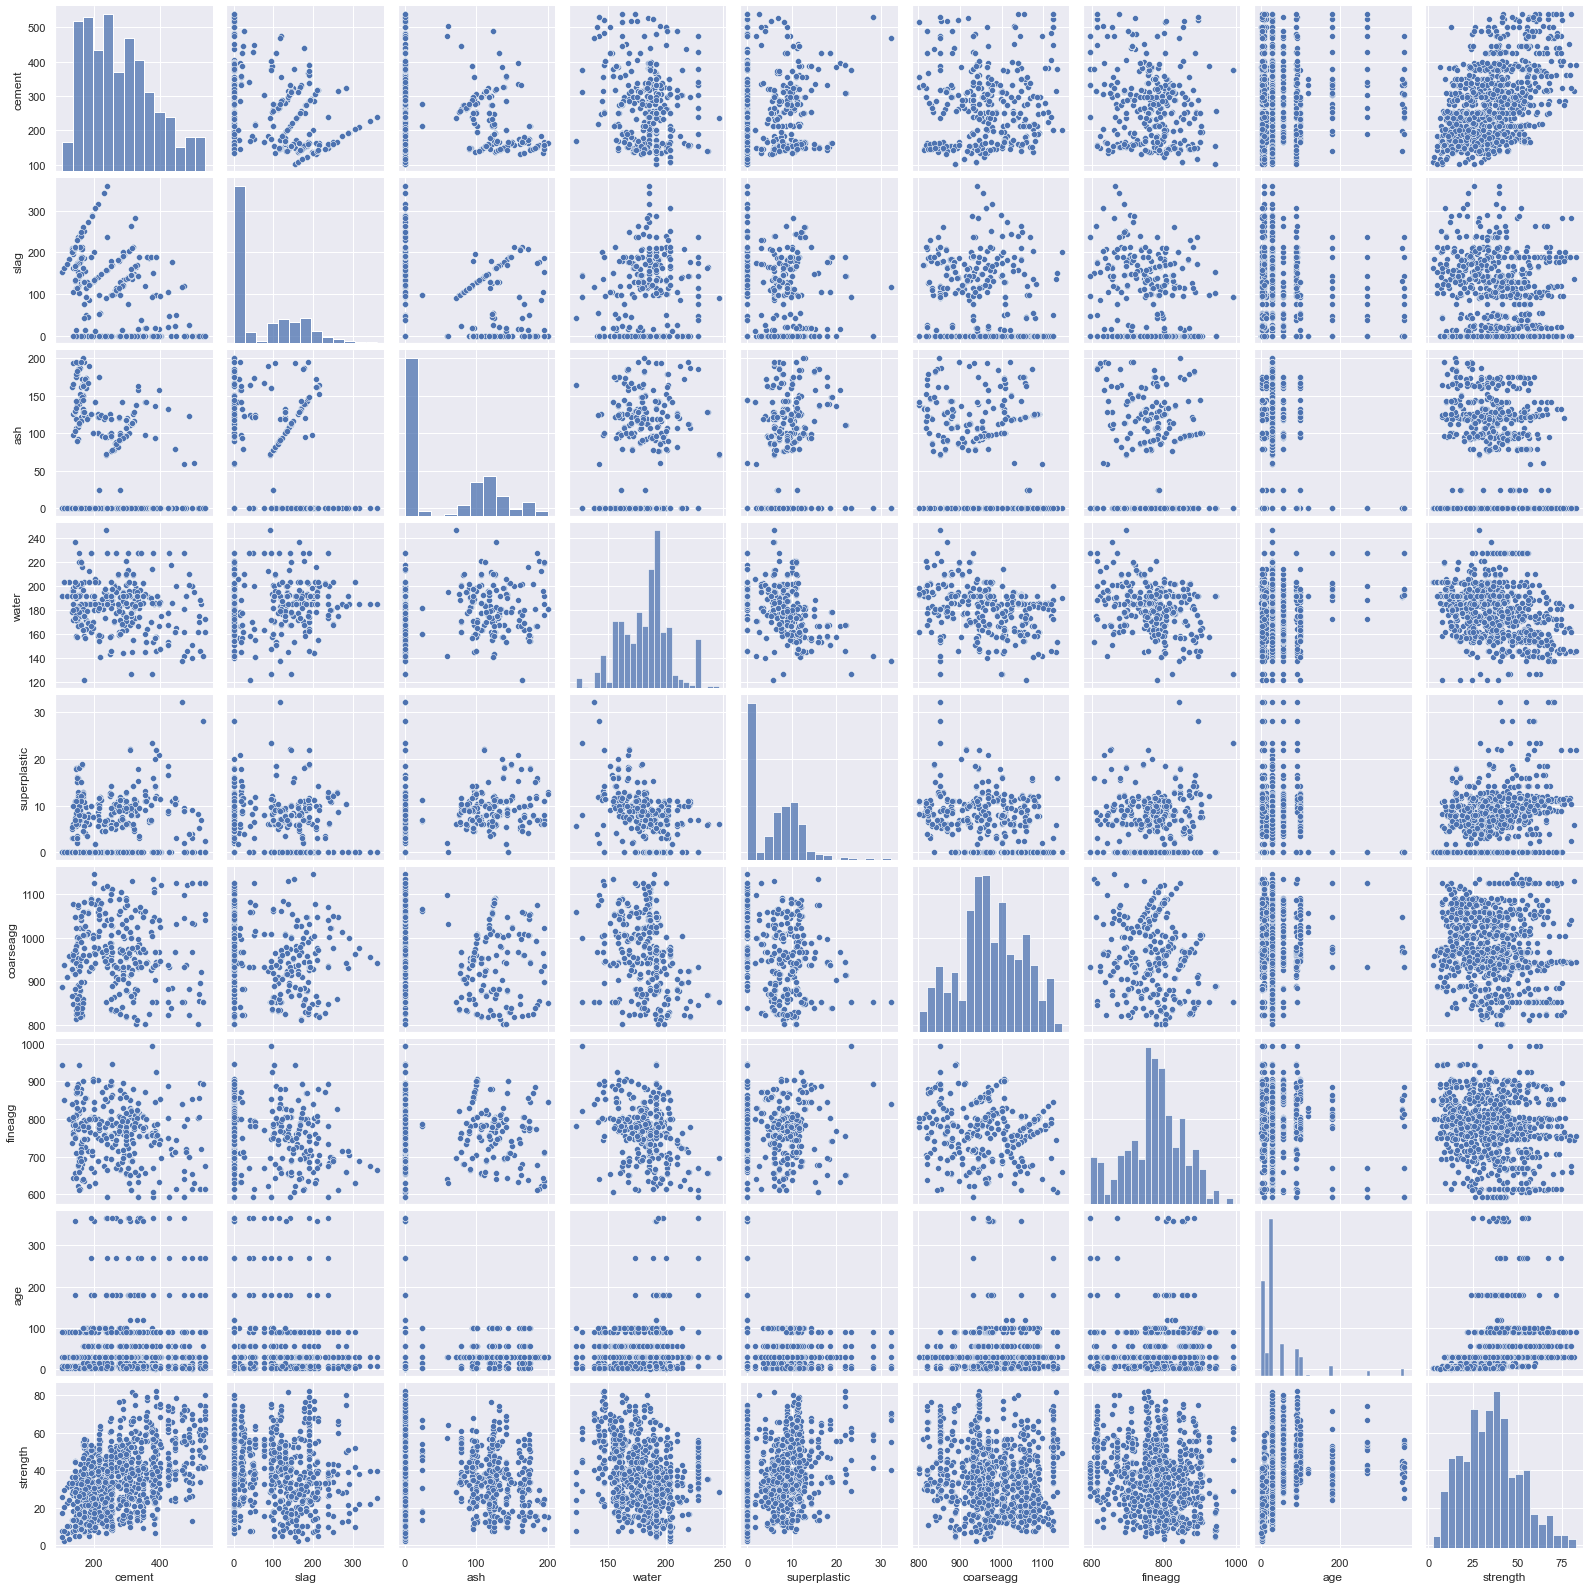

In [16]:
sns. pairplot(dataset)

Pariplot indicate positive correlation between strength and cement, and possible positive correlation between strength and superplastic. It is noticeable negative correlation between strength and amount of water in mixture, with some possible inverse higher order relationship. Relationship between strenght and age is not detectable from the graph above, but it might be detectable if taken into account amount of water.
There is noticable positive correlation between course and fine aggregate.


#### Some analysis of predictor variables against target variable

##### correlation of water and strength with age
It is not directly observable the relationship of the amount of water in mixture and strength, however if the idea that water evaporate from the concrete with time is taken into acount, then it might gives some clue on relationship of water with target variable. This concept is tested in code below, where the jointplot between water and strength is plotted for each discrete value of age. At the end, correlation between water and strength is plotted against age. 

Plot is for concrete 1 days old
Number of records is 2.
Correlation is 1.0.


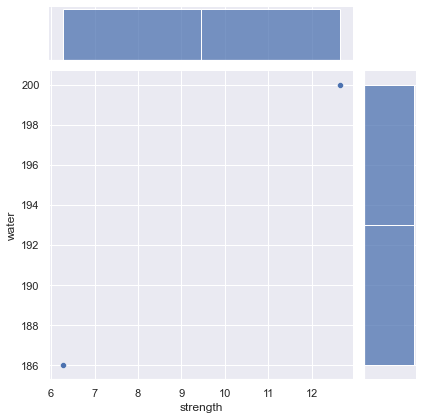

Plot is for concrete 3 days old
Number of records is 129.
Correlation is -0.5117245428349619.


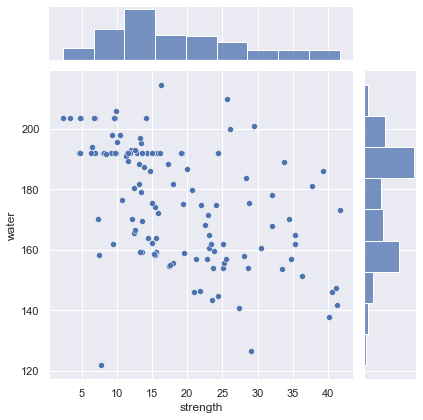

Plot is for concrete 7 days old
Number of records is 122.
Correlation is -0.5381469613883507.


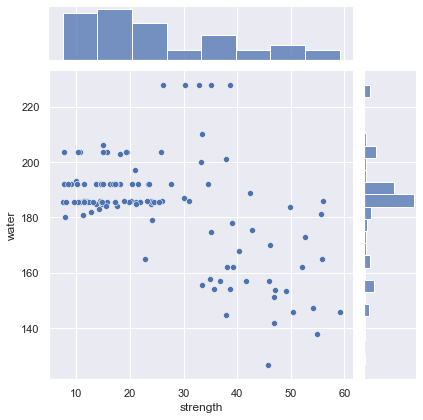

Plot is for concrete 14 days old
Number of records is 62.
Correlation is -0.302110385060628.


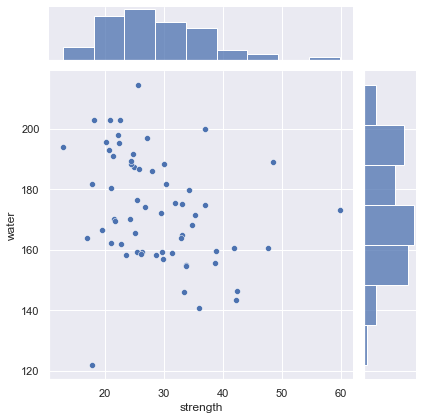

Plot is for concrete 28 days old
Number of records is 419.
Correlation is -0.3848053130820234.


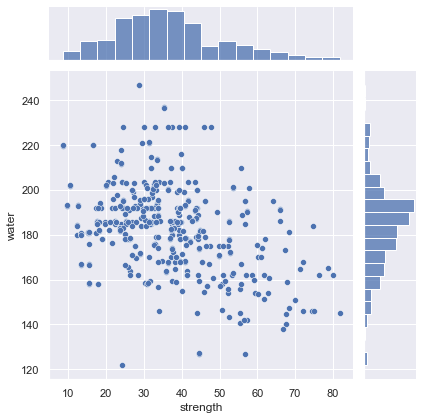

Plot is for concrete 56 days old
Number of records is 86.
Correlation is -0.3730967353739462.


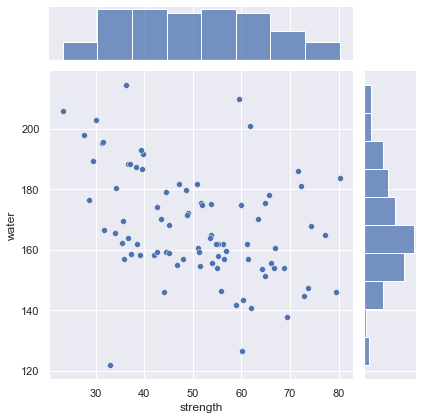

Plot is for concrete 90 days old
Number of records is 54.
Correlation is 0.06137616183293612.


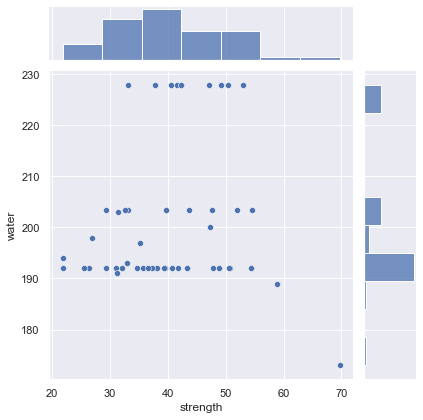

Plot is for concrete 91 days old
Number of records is 17.
Correlation is 0.13811865474978965.


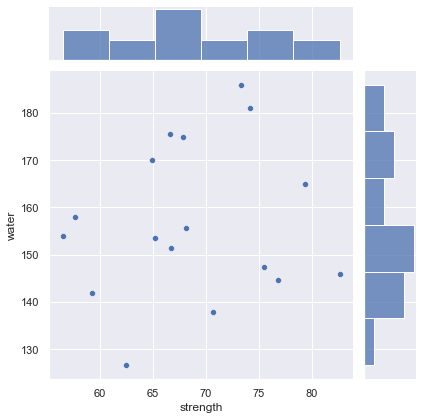

Plot is for concrete 100 days old
Number of records is 52.
Correlation is -0.4131076039215605.


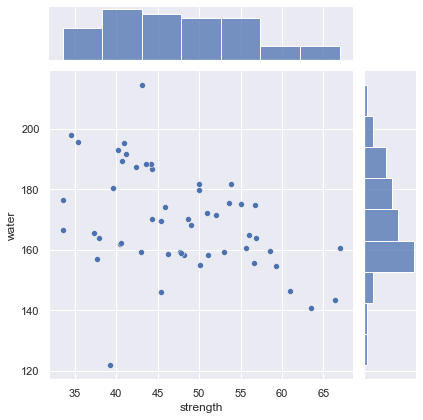

Plot is for concrete 120 days old
Number of records is 3.
Correlation is nan.


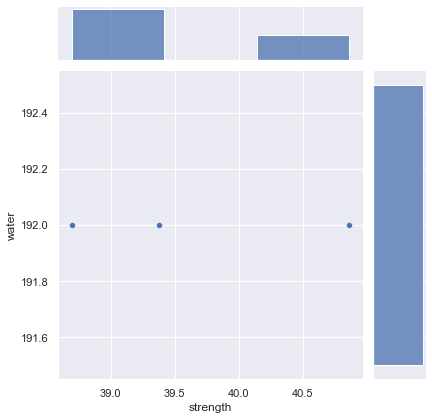

Plot is for concrete 180 days old
Number of records is 26.
Correlation is 0.042886642620584.


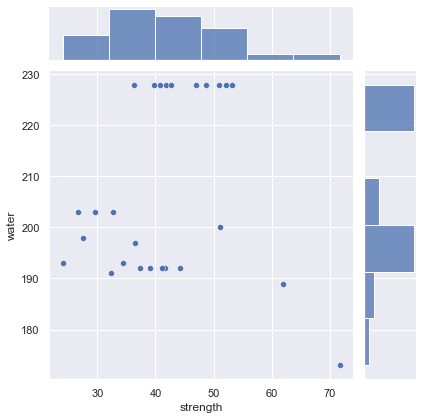

Plot is for concrete 270 days old
Number of records is 13.
Correlation is -0.8324838981205044.


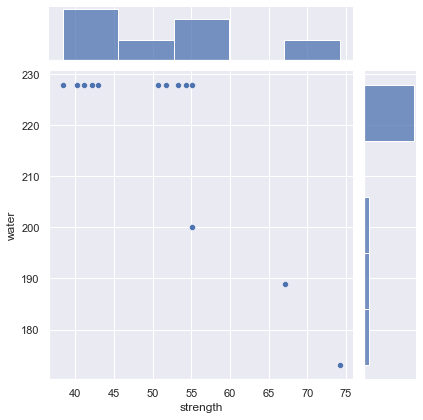

Plot is for concrete 360 days old
Number of records is 6.
Correlation is 0.8216954192965965.


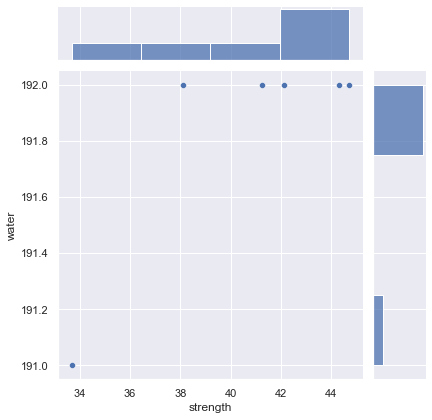

Plot is for concrete 365 days old
Number of records is 14.
Correlation is 0.7597499177758485.


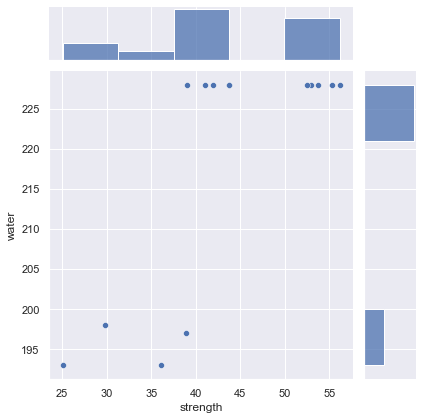

In [17]:
age=[]
correlation=[]
nr_records=[]
for i in sorted(dataset['age'].unique()):
    print('Plot is for concrete {} days old'.format(i))
    age.append(i)
    print('Number of records is {}.'.format(dataset[dataset['age']==i]['age'].value_counts().sum()))
    nr_records.append(dataset[dataset['age']==i]['age'].value_counts().sum())
    print('Correlation is {}.'.format(dataset[dataset['age']==i]['strength'].corr(dataset[dataset['age']==i]['water'])))
    correlation.append(dataset[dataset['age']==i]['strength'].corr(dataset[dataset['age']==i]['water']))
    sns.jointplot(dataset[dataset['age']==i]['strength'], dataset[dataset['age']==i]['water'])
    plt.show()

Relplot is used to plot age-correlation relationship, but also to show number of samples in each age group to indicate relevance of particular age-correlation pair. 

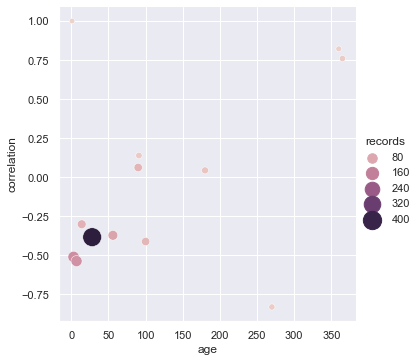

In [18]:
#graph that show age-correlation(between water and strength) relationship 
#with indication of the number of records
sns.relplot(data=pd.DataFrame({'age':age, 'correlation':correlation, 'records':nr_records}), 
           x="age", y="correlation", 
            size="records", sizes=(30,350),
           hue="records")

As a conclusion, there is slight negative correlation between amount of water and strength if the age of concrete is just few days(3-7). Such negative correlation is reduced, however still present, for concrete 28 days old where the most of the samples resides. The more the age rises, correlation goes into positive direction, where, finally correlation is high if the concrete is more than 360 days old. There are two exceptions: high positive correlation for a concrete 1 day old, and high negative correlation that is 270 days old. Those two might indicate there are outliers either in strength or water among those two groups. In addition, even though the transition from negative to positive correlation is identified throughout ages, it is hard to make solid conclusion, since there is discrepancy between number of samples for low ages and number of samples for high ages. In a group of 120 days, the correlation is inconclusive, since there are three samples with same amount of water and different strength.  

In [19]:
print('IQR outlier method:')
print('Low boundary for water is {} and high is {}.'.format(round((Q1-1.5*IQR)['water'],2),round((Q3+1.5*IQR)['water']),2))
print('Low boundary for strength is {} and high is {}.'.format(round((Q1-1.5*IQR)['strength'],2), round((Q3+1.5*IQR)['strength'],2)))

IQR outlier method:
Low boundary for water is 124.25 and high is 233.
Low boundary for strength is -9.93 and high is 79.77.


In [20]:
print('+-3 std from mean method:')
print('Low boundary for water is {} and high is {}.'.format(round(dataset['water'].mean()-3*dataset['water'].std(),2), round(dataset['water'].mean()+3*dataset['water'].std(),2)))
print('Low boundary for strength is {} and high is {}.'.format(round(dataset['strength'].mean()-3*dataset['strength'].std(),2), round(dataset['strength'].mean()+3*dataset['strength'].std(),2)))

+-3 std from mean method:
Low boundary for water is 118.06 and high is 246.09.
Low boundary for strength is -13.6 and high is 84.1.


NOTE: lower boundary for strenght is meaningless since it should be positive number.

In [21]:
dataset[dataset['age']==1][['water', 'strength']]

,water,strength
502,200.0,12.64
831,186.0,6.27


In [22]:
dataset[dataset['age']==270][['water', 'strength']]

,water,strength
149,228.0,41.15
256,189.0,67.11
262,228.0,51.73
270,200.0,55.16
297,228.0,42.13
313,173.0,74.17
570,228.0,50.66
623,228.0,53.30
632,228.0,54.38
850,228.0,43.01


Even though it looked like there might be outliers impacting correlation of those two datapoints, comparison of water and strength data for age=1 and age=270 reveals no outliers among those datapoints.

##### grouping of dataset based on ash, slag and superplastic
In univariate analysis, possible existance of two gaussians is indicated in variables slag, ash and superplastic. This idea is further explored in this section. The principle is to divide dataset into two groups based on certain treshold for each of above mentioned variables.   

For each of identified variables the cutoff is aproximated from displot, then the size of each group is derived from .shape function to verify balance between groups and finaly, the gain of such activity is verified through heatmap. In a heatmap a difference between absolute value of correlations between all varibales(including target variable) before split and absolute value of correlation after the split is derived for both groups. Such value, if it is positive, indicate lower correlation after split, and, if negative, higher correlation after split. Absolute value is taken for both correlations to avoid false gain/reduction in correlation if the correlation before and after split are of different signs. The more negative indication on heatmap, better the correlation is for that particular group compared to whole dataset.  

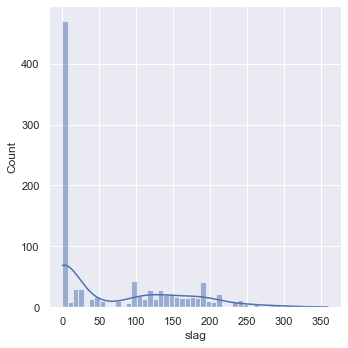

In [23]:
sns.displot(dataset['slag'], bins=50, kde=True)

In [24]:
dataset[dataset['slag']<60].shape

(580, 9)

In [25]:
dataset[dataset['slag']>=60].shape

(425, 9)

<AxesSubplot:>

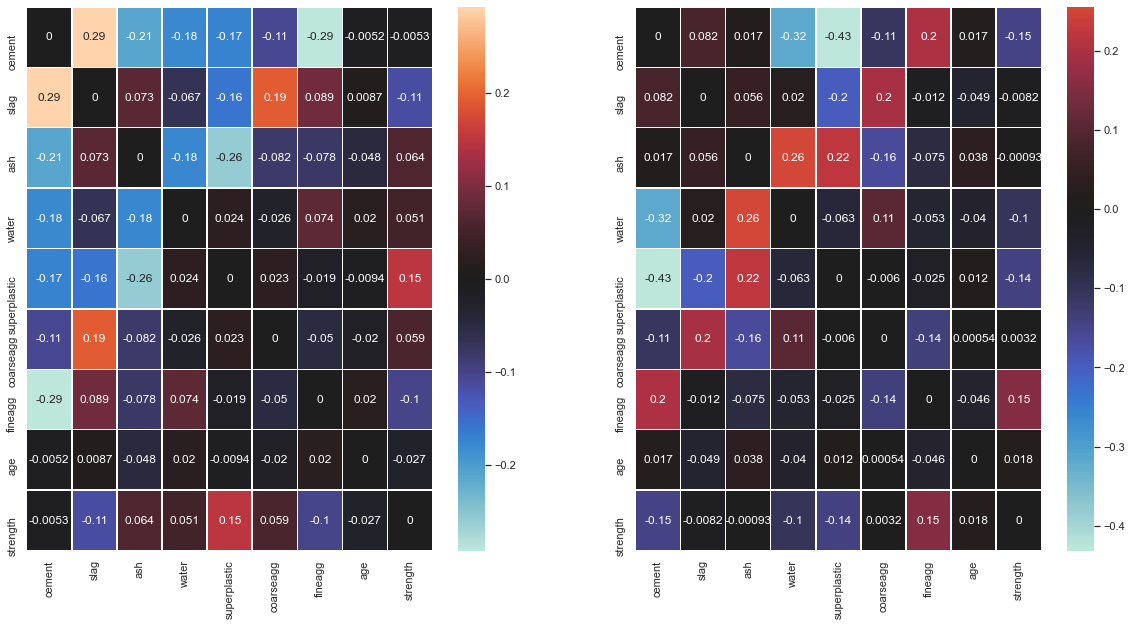

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
sns.heatmap((abs(dataset.corr())-abs(dataset[dataset['slag']<60].corr())), center=0, annot=True, linewidths=.5, ax=axs[0])
sns.heatmap((abs(dataset.corr())-abs(dataset[dataset['slag']>=60].corr())), center=0, annot=True, linewidths=.5, ax=axs[1])

In [27]:
#total sum of all gains/losses in correlation for strength for group slag_less_60
(abs(dataset.corr())-abs(dataset[dataset['slag']<60].corr()))['strength'].sum()

0.07603353506122336

In [28]:
#total sum of all gains/losses in correlation for strength for group slag_more_eq_60
(abs(dataset.corr())-abs(dataset[dataset['slag']>=60].corr()))['strength'].sum()

-0.22331909062770214

It can be seen there is a gain in correlation between target varibale and other variables for group where slag is more or equal to 60. For the other group, there is loss in correlation, however, insignificant.

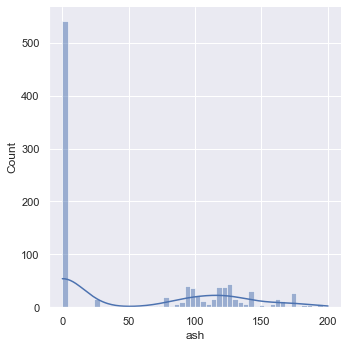

In [29]:
sns.displot(dataset['ash'], bins=50, kde=True)

In [30]:
dataset[dataset['ash']<50].shape

(556, 9)

In [31]:
dataset[dataset['ash']>=50].shape

(449, 9)

<AxesSubplot:>

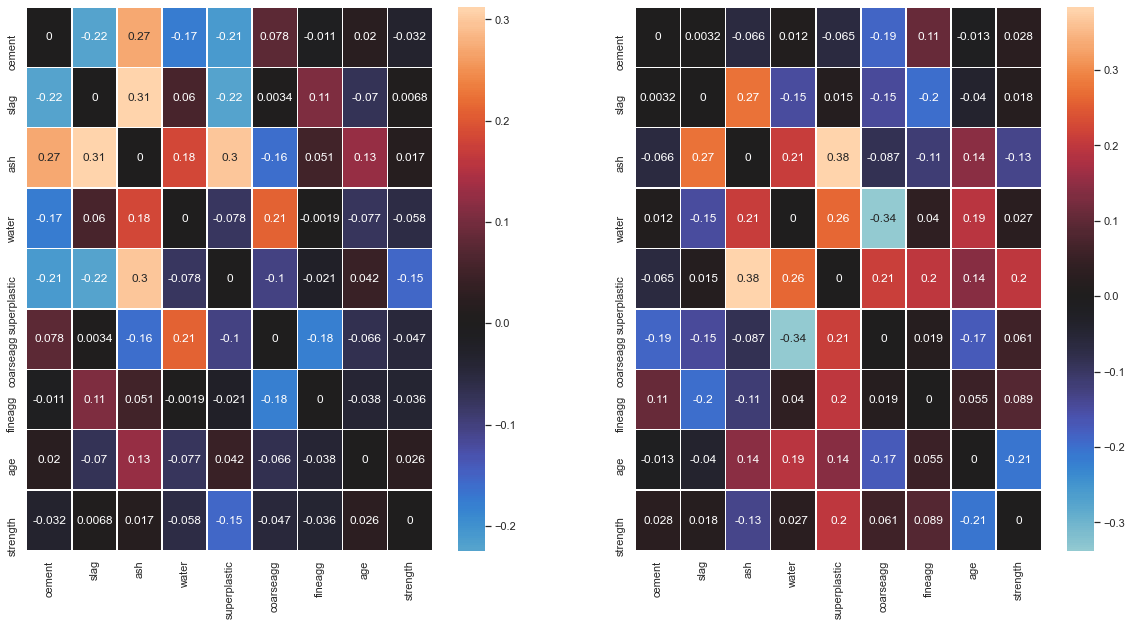

In [32]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
sns.heatmap((abs(dataset.corr())-abs(dataset[dataset['ash']<50].corr())), center=0, annot=True, linewidths=.5, ax=axs[0])
sns.heatmap((abs(dataset.corr())-abs(dataset[dataset['ash']>=50].corr())), center=0, annot=True, linewidths=.5, ax=axs[1])

In [33]:
#total sum of all gains/losses in correlation for strength for group ash_less_50
(abs(dataset.corr())-abs(dataset[dataset['ash']<50].corr()))['strength'].sum()

-0.27658096189772996

In [34]:
#total sum of all gains/losses in correlation for strength for group ash_greater_eq_60
(abs(dataset.corr())-abs(dataset[dataset['ash']>=50].corr()))['strength'].sum()

0.08378708694060866

When the dataset is grouped based on ash with a treshold of 50, the result is opposite compared to slag. Correlation gain is identified in first group.

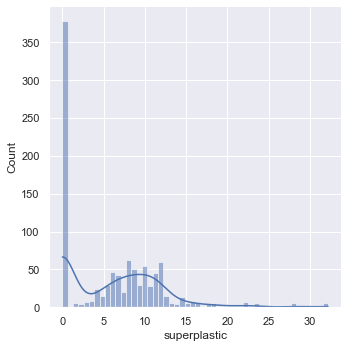

In [35]:
sns.displot(dataset['superplastic'], bins=50, kde=True)

In [36]:
dataset[dataset['superplastic']<4].shape

(410, 9)

In [37]:
dataset[dataset['superplastic']>=4].shape

(595, 9)

<AxesSubplot:>

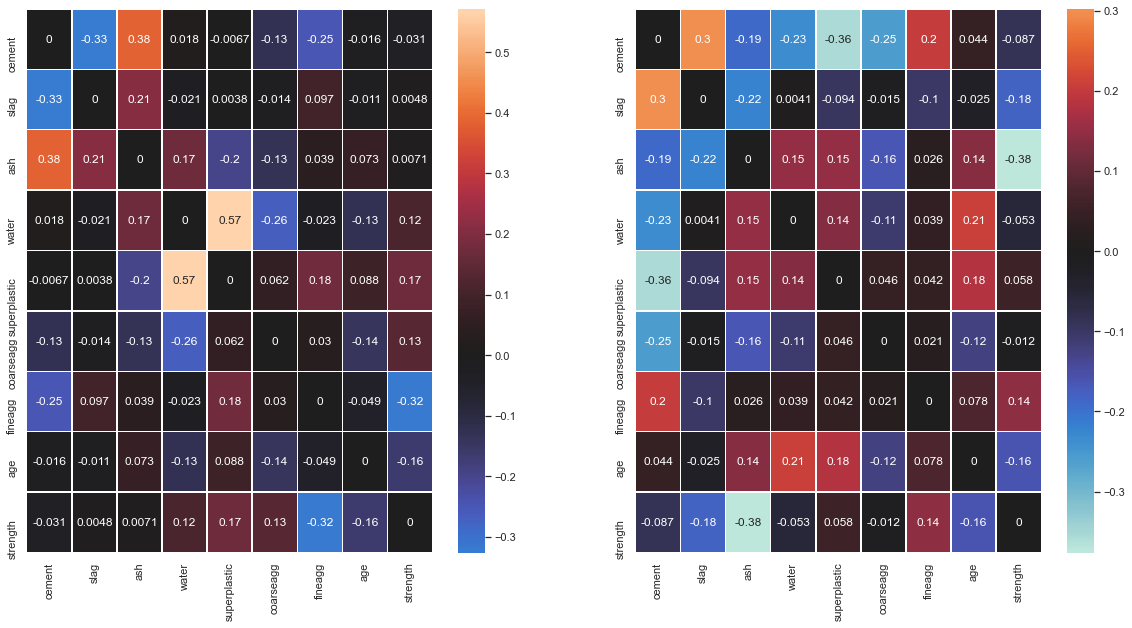

In [38]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
sns.heatmap((abs(dataset.corr())-abs(dataset[dataset['superplastic']<4].corr())), center=0, annot=True, linewidths=.5, ax=axs[0])
sns.heatmap((abs(dataset.corr())-abs(dataset[dataset['superplastic']>=4].corr())), center=0, annot=True, linewidths=.5, ax=axs[1])

In [39]:
#total sum of all gains/losses in correlation for strength for group superplastic_less_4
(abs(dataset.corr())-abs(dataset[dataset['superplastic']<4].corr()))['strength'].sum()

-0.08091055066628906

In [40]:
#total sum of all gains/losses in correlation for strength for group superplastic_greater_eq_4
(abs(dataset.corr())-abs(dataset[dataset['superplastic']>=4].corr()))['strength'].sum()

-0.6684162888059791

When the groups are formated based on supeplastic with a treshold of 4, there is gain in correlation with regards to target variable for both groups, as indicated in outputs above.

Overall, it might be worth trying to split datasets into groups based on certain value of those three variables, becuase there is a gain in correlation with regards to target varibale at least in one of the groups without decrease in other, or, as it is shown, the gain has been achieved in both groups if groups are defined based on superplastic variable. To reduce number of datasets, the last grouping will be used to train models.

In [41]:
dataset_plastic_less_4=dataset[dataset['superplastic']<4]
dataset_plastic_more_4=dataset[dataset['superplastic']>=4]

##### Correlation between variables

<AxesSubplot:>

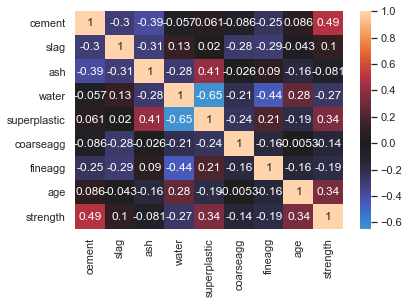

In [42]:
#correlation for dataset
sns.heatmap(dataset.corr(), center=0, annot=True)

Generally there are no strong correlations between variables in dataset. The highest correlation is between water and superplastic and is -0.65. One of these two columns might be removed from dataset before trainning. In such scenario, water varibale should be removed, since it has greater number of outliers, hence, it may be considered as less reliable.  

<AxesSubplot:>

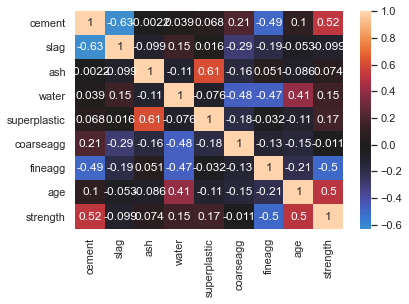

In [43]:
#correlation for dataset_plastic_less_4
sns.heatmap(dataset_plastic_less_4.corr(), center=0, annot=True)

Similar observations as for dataset applyies for dataset_plastic_less_4, where the highest correlation is between slag and cement of -0.63. 

<AxesSubplot:>

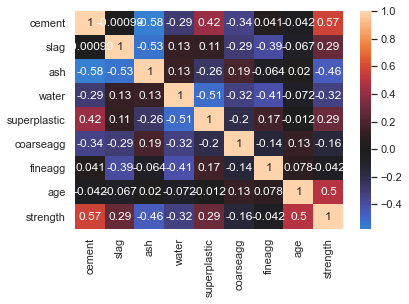

In [44]:
#correlation for dataset_plastic_more_4
sns.heatmap(dataset_plastic_more_4.corr(), center=0, annot=True)

## 3. Feature Engineering techniques

### 3.1 Identify opportunities (if any) to extract new features from existing features, drop a feature(if required). 

There might be opportunity to provide a new fetaure like cement_replacement with combination of ash and slag or a combination of coarse and fine aggregate in new vairable called aggregate. Such opportunities are explored with code below. Heatmap may be used to identify if such new variables shows high level of correlation with original variables. 

In addition water and supeplastic show decent negative correlation in original dataset of -0.65. Such correlation is eliminated in splitted dataset (based on supeplastic), however split cuased higher positive correlation between superplastic and ash (0.61) in dataset_plastic_less_4.

In [45]:
def columns_add(column_1, column_2):
    return(column_1+column_2)

In [46]:
dataset['cement_replacement']=columns_add(dataset['ash'], dataset['slag'])
dataset_plastic_less_4['cement_replacement']=columns_add(dataset_plastic_less_4['ash'], dataset_plastic_less_4['slag'])
dataset_plastic_more_4['cement_replacement']=columns_add(dataset_plastic_more_4['ash'], dataset_plastic_more_4['slag'])

In [47]:
dataset['aggregate']=columns_add(dataset['coarseagg'], dataset['fineagg'])
dataset_plastic_less_4['aggregate']=columns_add(dataset_plastic_less_4['coarseagg'], dataset_plastic_less_4['fineagg'])
dataset_plastic_more_4['aggregate']=columns_add(dataset_plastic_more_4['coarseagg'], dataset_plastic_more_4['fineagg'])

<AxesSubplot:>

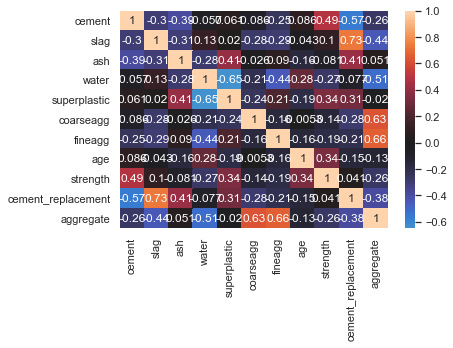

In [48]:
sns.heatmap(dataset.corr(), center=0, annot=True)

<AxesSubplot:>

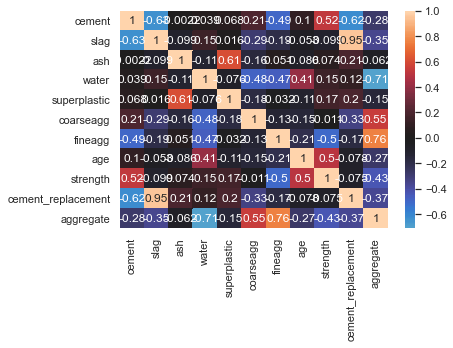

In [49]:
sns.heatmap(dataset_plastic_less_4.corr(), center=0, annot=True)

<AxesSubplot:>

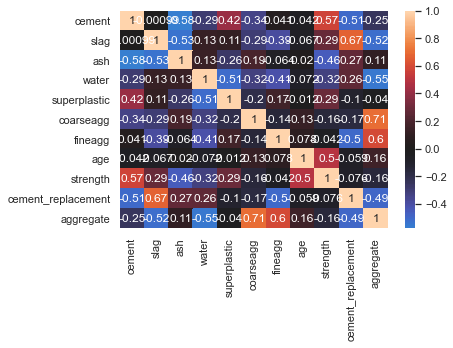

In [50]:
sns.heatmap(dataset_plastic_more_4.corr(), center=0, annot=True)

As it might have been expected, such activity where we applied addition between columns caused relatively strong correlation between original columns and generated ones. It might not be a good strategy after all.

In [51]:
dataset.drop(columns=['cement_replacement', 'aggregate'], inplace=True)

In [52]:
dataset_plastic_less_4.drop(columns=['cement_replacement', 'aggregate'], inplace=True)
dataset_plastic_more_4.drop(columns=['cement_replacement', 'aggregate'], inplace=True)

### 3.2 Get the data model ready and do a train test split.

In [53]:
#split of original dataset
X1_train, X1_test, y1_train, y1_test=train_test_split(dataset[dataset.columns.drop('strength')], dataset['strength'], test_size=0.3, random_state=7)

In [54]:
#split of datasets resulted from the split based on superplastic
X21_train, X21_test, y21_train, y21_test=train_test_split(dataset_plastic_less_4[dataset_plastic_less_4.columns.drop('strength')], dataset_plastic_less_4['strength'], test_size=0.3, random_state=7)
X22_train, X22_test, y22_train, y22_test=train_test_split(dataset_plastic_more_4[dataset_plastic_more_4.columns.drop('strength')], dataset_plastic_more_4['strength'], test_size=0.3, random_state=7)

Cross validation technique and gridsearch or random search technique will employ kfold technique to perform cross validation or to find best set of hyperparameters. In such circumstances, it is ok to divide dataset only on train and test, since train dataset will be splitted n times while kFold techique is used, and will be used as train and test while performing cross validation or grid/random search. It enables preservance of test data for final validation (as unseen data). This approach is suitable, since the number of datapoints is relatively small.

### 3.3 Decide on the complexity of the model, should it be a simple linear model in terms of parameters or would a quadratic or higher degree.

Heatmaps of correlation of all three datasets do not show significant linear correlation between target variable and independent variables, however, there might be some other, nonlinear. It is hard to establish such relation, however, it is worth of exploring additional dimensions. Additional dimensions/features might be extracted from already existing variables, e.g. squareing the variable or combining with others. To transform dataset in such way, object of type PolynomialFeatures can be used. Such transformation can produce high amount of additional variables/dimensions, and, since our dataset has relatively small number of datapoints, to limit number of additional features, degree parameter is set to 2.

In [55]:
poly=PolynomialFeatures(degree=2, interaction_only=True)

In [56]:
column_extraction=pd.DataFrame(poly.fit_transform(X1_train))

columns_for_processing_poly=[]

for i in (column_extraction.columns):
    columns_for_processing_poly.append('column_{}'.format(i))

In [57]:
X1_train2=pd.DataFrame(poly.fit_transform(X1_train), columns=columns_for_processing_poly)

X1_test2=pd.DataFrame(poly.fit_transform(X1_test), columns=columns_for_processing_poly)

X21_train2=pd.DataFrame(poly.fit_transform(X21_train), columns=columns_for_processing_poly)
X21_test2=pd.DataFrame(poly.fit_transform(X21_test), columns=columns_for_processing_poly)

X22_train2=pd.DataFrame(poly.fit_transform(X22_train), columns=columns_for_processing_poly)
X22_test2=pd.DataFrame(poly.fit_transform(X22_test), columns=columns_for_processing_poly)

In addition to already existing 3 datasets, 3 more are added to be used for trainning models.

## 4. Creating a model and Tuning it

### 4.1 Algorithms that you think will be suitable for this project.

Target variable is continual, hence regression methods should be used like LinearRegression model, and regularisation models like Ridge and Lasso. AdaBoostRegressor and BaggingRegressor may be used as well to solve this regression problem.

Since there are 6 datasets to be used for trainning, preprocessing of all 6 would take too much space and time, so pipeline will be employed here. In addition, pipeline provides standardized way to deal with data. All datasets will undergo the same preprocessing steps.

Removing of outliers should be done separatelly on each dataset used for trainning to avoid data leak from train to test data in kFold technique. To make it possible in situation where kFold technique is used pipeline should include such transformation, however, such transformer was not available/could not be found. In response, custom transformer is created - OutlierRemoval. It has been design to conform to basic rule of the pipeline - to have fit and transform functions. For convenience two class parameters are defined - treshold and strategy for replacement of outliers as describet in comment of it's code.

In [58]:
#Custom made transformer which takes dataframe and replace outliers with mean or median

#class paramters are treshold and strategy to replace outliers
#treshold can be any int value in range [0:inf]
#strategy can be one of following ['mean', 'median']

class OutliersRemoval:
    
    def __init__(self, treshold, strategy):
        self.treshold=treshold
        self.strategy=strategy
    
    def fit(self, data, y=None):
        self.data=data.copy()
        self.z=np.abs(stats.zscore(self.data))
        return (self.z)
    
    def transform(self, data, y=None):
        self.data=data
        self.z=self.fit(self.data)
        if self.strategy=='median':
            self.median=self.data.median()
            for i in np.where(self.z>3)[0]:
                for j in np.where(self.z>3)[1]:
                    self.data.iloc[i,j]=self.median[j]
        elif self.strategy=='mean':
            self.mean=data.mean()
            for i in np.where(self.z>3)[0]:
                for j in np.where(self.z>3)[1]:
                    self.data.iloc[i,j]=self.mean[j]
        return(self.data)
    
    def fit_transform(self, data, y=None):
        self.data=data.copy()
        self.z=np.abs(stats.zscore(self.data))
        if self.strategy=='median':
            self.median=self.data.median()
            for i in np.where(self.z>self.treshold)[0]:
                for j in np.where(self.z>self.treshold)[1]:
                    self.data.iloc[i,j]=self.median[j]
        elif self.strategy=='mean':
            self.mean=data.mean()
            for i in np.where(self.z>3)[0]:
                for j in np.where(self.z>3)[1]:
                    self.data.iloc[i,j]=self.mean[j]
        return(self.data)
    
            

ColumnTransformer object is used to control transformation of independent variable set (independent variable columns)

In [59]:
#columns to preprocess (all columns except target column)
columns_for_processing=dataset.columns.drop('strength')

#transforms to be used on above columns:
transformer=Pipeline([('outliers_removal', OutliersRemoval(3, 'median')),('scaler', StandardScaler())])

#columnTransformer object takes transformers pipeline and applies it on selected columns
preprocessor=ColumnTransformer([('transformer', transformer, columns_for_processing)])

In [60]:

preprocessor_poly=ColumnTransformer([('transformer', transformer, columns_for_processing_poly)])


Two preprocessor object are created since columns are different in datasets where polynomial features are added.

In [61]:
#pipelines for diferent model algorithms
lin_reg_model=Pipeline([('preprocessor', preprocessor),
                       ('regressor', LinearRegression())])

#lasso_model=Pipeline([('preprocessor', preprocessor),
#                    ('regressor'), Lasso()])

ridge_model=Pipeline([('preprocessor', preprocessor),
                     ('regressor', Ridge(random_state=7))])

bagging_model=Pipeline([('preprocessor', preprocessor),
                       ('regressor', BaggingRegressor(random_state=7))])

adaBoost_model=Pipeline([('preprocessor', preprocessor),
                        ('regressor', AdaBoostRegressor(random_state=7))])

#pipelines for diferent model algorithms for polynomial features -- difference in columns for processing
lin_reg_model_poly=Pipeline([('preprocessor', preprocessor_poly),
                       ('regressor', LinearRegression())])

#lasso_model=Pipeline([('preprocessor', preprocessor),
#                    ('regressor'), Lasso()])

ridge_model_poly=Pipeline([('preprocessor', preprocessor_poly),
                     ('regsressor', Ridge(random_state=7))])

bagging_model_poly=Pipeline([('preprocessor', preprocessor_poly),
                       ('regressor', BaggingRegressor(random_state=7))])

adaBoost_model_poly=Pipeline([('preprocessor', preprocessor_poly),
                        ('regressor', AdaBoostRegressor(random_state=7))])

In [62]:

list_pipelines=[lin_reg_model, ridge_model, bagging_model, adaBoost_model]
list_pipelines_poly=[lin_reg_model_poly, ridge_model_poly, bagging_model_poly, adaBoost_model_poly]
list_pipelines_names=['lin_reg_model','ridge_model','bagging_model','adaBoost_model']
list_pipelines_names_poly=['lin_reg_model_poly','ridge_model_poly','bagging_model_poly','adaBoost_model_poly']
datasets_df=pd.DataFrame({"1": [X1_train, y1_train, X1_test, y1_test],
                         "21":[X21_train, y21_train, X21_test, y21_test],
                         "22":[X22_train, y22_train,X22_test, y22_test],
                          "1_poly": [X1_train2, y1_train,X1_test2, y1_test],
                         "21_poly":[X21_train2, y21_train,X21_test2, y21_test],
                         "22_poly":[X22_train2, y22_train,X22_test2,y22_test]}, index=['train', 'train', 'test', 'test'])

Trainning of all models happens here. results are saved in corresponding lists for later printing in a dataframe.

In [63]:
list_of_models=[]
X1_train_score=[]
X21_train_score=[]
X22_train_score=[]

X1_test_score=[]
X21_test_score=[]
X22_test_score=[]

#trainning all models happens here
j=0
for i in list_pipelines:
    i.fit(datasets_df['1'][0], datasets_df['1'][1])
    score_predict=round(r2_score(datasets_df['1'][1], i.predict(datasets_df['1'][0])),2)
    score_test=round(r2_score(datasets_df['1'][3], i.predict(datasets_df['1'][2])),2)
    print('Scores of model {}:'.format(list_pipelines_names[j]))
    list_of_models.append(list_pipelines_names[j])
    print("On dataset 1 for train data is {}, and for test data is {}".format(score_predict, score_test))
    X1_train_score.append(score_predict)
    X1_test_score.append(score_test)
    
    i.fit(datasets_df['21'][0], datasets_df['21'][1])
    score_predict=round(r2_score(datasets_df['21'][1], i.predict(datasets_df['21'][0])),2)
    score_test=round(r2_score(datasets_df['21'][3], i.predict(datasets_df['21'][2])),2)
    print('Scores of model {}:'.format(list_pipelines_names[j]))
    print("On dataset 21 for train data is {}, and for test data is {}".format(score_predict, score_test))
    X21_train_score.append(score_predict)
    X21_test_score.append(score_test)
    
    i.fit(datasets_df['22'][0], datasets_df['22'][1])
    score_predict=round(r2_score(datasets_df['22'][1], i.predict(datasets_df['22'][0])),2)
    score_test=round(r2_score(datasets_df['22'][3], i.predict(datasets_df['22'][2])),2)
    print('Scores of model {}:'.format(list_pipelines_names[j]))
    print("On dataset 22 for train data is {}, and for test data is {}".format(score_predict, score_test))
    X22_train_score.append(score_predict)
    X22_test_score.append(score_test)

    print('\n')
    j=j+1

j=0
for i in list_pipelines_poly:
    i.fit(datasets_df['1_poly'][0], datasets_df['1_poly'][1])
    score_predict=round(r2_score(datasets_df['1_poly'][1], i.predict(datasets_df['1_poly'][0])),2)
    score_test=round(r2_score(datasets_df['1_poly'][3], i.predict(datasets_df['1_poly'][2])),2)
    print('Scores of model {}:'.format(list_pipelines_names_poly[j]))
    print("On dataset 1 for train data is {}, and for test data is {}".format(score_predict, score_test))
    list_of_models.append(list_pipelines_names_poly[j])
    X1_train_score.append(score_predict)
    X1_test_score.append(score_test)
    
    i.fit(datasets_df['21_poly'][0], datasets_df['21_poly'][1])
    score_predict=round(r2_score(datasets_df['21_poly'][1], i.predict(datasets_df['21_poly'][0])),2)
    score_test=round(r2_score(datasets_df['21_poly'][3], i.predict(datasets_df['21_poly'][2])),2)
    print('Scores of model {}:'.format(list_pipelines_names_poly[j]))
    print("On dataset 21 for train data is {}, and for test data is {}".format(score_predict, score_test))
    X21_train_score.append(score_predict)
    X21_test_score.append(score_test)
   
    i.fit(datasets_df['22_poly'][0], datasets_df['22_poly'][1])
    score_predict=round(r2_score(datasets_df['22_poly'][1], i.predict(datasets_df['22_poly'][0])),2)
    score_test=round(r2_score(datasets_df['22_poly'][3], i.predict(datasets_df['22_poly'][2])),2)
    print('Scores of model {}:'.format(list_pipelines_names_poly[j]))
    print("On dataset 22 for train data is {}, and for test data is {}".format(score_predict, score_test))
    X22_train_score.append(score_predict)
    X22_test_score.append(score_test)
    
    print('\n')
    j=j+1


Scores of model lin_reg_model:
On dataset 1 for train data is 0.67, and for test data is 0.67
Scores of model lin_reg_model:
On dataset 21 for train data is 0.54, and for test data is 0.61
Scores of model lin_reg_model:
On dataset 22 for train data is 0.76, and for test data is 0.73


Scores of model ridge_model:
On dataset 1 for train data is 0.67, and for test data is 0.67
Scores of model ridge_model:
On dataset 21 for train data is 0.54, and for test data is 0.61
Scores of model ridge_model:
On dataset 22 for train data is 0.76, and for test data is 0.73


Scores of model bagging_model:
On dataset 1 for train data is 0.97, and for test data is 0.87
Scores of model bagging_model:
On dataset 21 for train data is 0.95, and for test data is 0.85
Scores of model bagging_model:
On dataset 22 for train data is 0.98, and for test data is 0.82


Scores of model adaBoost_model:
On dataset 1 for train data is 0.78, and for test data is 0.75
Scores of model adaBoost_model:
On dataset 21 for tra

Dataframe of scores is organized in such way that columns represents datasets - X1_train is train dataset of original dataset, X21_tran and X22_train are training datasets of splitted datasets based on superplastic and so on.

In [64]:
pd.DataFrame({'model':list_of_models, 
             'X1_train':X1_train_score,
             'X1_test':X1_test_score,
             'X21_train':X21_train_score,
             'X21_test':X21_test_score,
             'X22_train':X22_train_score,
             'X22_test':X22_test_score})

,model,X1_train,X1_test,X21_train,X21_test,X22_train,X22_test
0,lin_reg_model,0.67,0.67,0.54,0.61,0.76,0.73
1,ridge_model,0.67,0.67,0.54,0.61,0.76,0.73
2,bagging_model,0.97,0.87,0.95,0.85,0.98,0.82
3,adaBoost_model,0.78,0.75,0.82,0.76,0.84,0.76
4,lin_reg_model_poly,0.75,-2.84,0.72,0.68,0.82,0.51
5,ridge_model_poly,0.74,0.60,0.65,0.60,0.82,0.61
6,bagging_model_poly,0.93,0.75,0.95,0.83,0.97,0.86
7,adaBoost_model_poly,0.76,0.67,0.84,0.77,0.87,0.81


As a result, it can be seen that most of the models were overtrained where polynomial features were used. It is somehow expected, since polynomial features adds sharp peaks and valleys in model space to fit the best trainning data. Some models, like lin_reg_model and ridge_models perfomr very badly, and there is even one model that had negative score (it is worst then random), however, it should be separately explored. Models that use DT are all overfit, so those might show better perfomance once the regularisation (adjustments of hyperparameters) is employed. 

### 4.2 Use Kfold Cross-Validation to evaluate model performance. Use appropriate metrics and make a DataFrame to compare models w.r.t their metrics. (at least 3 algorithms, one bagging and one boosting based algorithms have to be there and try to achieve 90% accuracy on testing set)

In this section cross validation tehcnique has been performed to find average R2 score of each model. kfold object of type KFold is used as input paramtere for cv. Number of splits is set to 10 and radnom state is kept the same

In [89]:

kfold=KFold(n_splits=10, shuffle=True, random_state=7)

In [90]:
X1_cross_val_train=[]
X21_cross_val_train=[]
X22_cross_val_train=[]


j=0
for i in list_pipelines:
    
    #calculating cros_val_score
    cross_val_score_train=round((cross_val_score(i,datasets_df['1'][0], datasets_df['1'][1], cv=kfold, scoring='r2').mean()),2)
    print('Cross validation scores of model {}:'.format(list_pipelines_names[j]))
    print("On dataset 1 is {}".format(cross_val_score_train))
    X1_cross_val_train.append(cross_val_score_train)
    
    cross_val_score_train=round((cross_val_score(i,datasets_df['21'][0], datasets_df['21'][1], cv=kfold, scoring='r2')).mean(),2)
    print('Cross validation scores of model {}:'.format(list_pipelines_names[j]))
    print("On dataset 21 is {}".format(cross_val_score_train))
    X21_cross_val_train.append(cross_val_score_train)
    
    cross_val_score_train=round((cross_val_score(i,datasets_df['22'][0], datasets_df['22'][1], cv=kfold, scoring='r2')).mean(),2)
    print('Cross validation scores of model {}:'.format(list_pipelines_names[j]))
    print("On dataset 22 is {}".format(cross_val_score_train))
    X22_cross_val_train.append(cross_val_score_train)
    
    print('\n')
    j=j+1
    
j=0
for i in list_pipelines_poly:
    
    cross_val_score_train=round((cross_val_score(i,datasets_df['1_poly'][0], datasets_df['1_poly'][1], cv=kfold, scoring='r2')).mean(),2)
    print('Cross validation scores of model {}:'.format(list_pipelines_names_poly[j]))
    print("On dataset 1 is {}".format(cross_val_score_train))
    X1_cross_val_train.append(cross_val_score_train)
    
    cross_val_score_train=round((cross_val_score(i,datasets_df['21_poly'][0], datasets_df['21_poly'][1], cv=kfold, scoring='r2')).mean(),2)
    print('Cross validation scores of model {}:'.format(list_pipelines_names_poly[j]))
    print("On dataset 21 is {}".format(cross_val_score_train))
    X21_cross_val_train.append(cross_val_score_train)
    
    cross_val_score_train=round((cross_val_score(i,datasets_df['22_poly'][0], datasets_df['22_poly'][1], cv=kfold, scoring='r2')).mean(),2)
    print('Cross validation scores of model {}:'.format(list_pipelines_names_poly[j]))
    print("On dataset 22 is {}".format(cross_val_score_train))
    X22_cross_val_train.append(cross_val_score_train)
    
    print('\n')
    j=j+1

Cross validation scores of model lin_reg_model:
On dataset 1 is 0.6
Cross validation scores of model lin_reg_model:
On dataset 21 is 0.38
Cross validation scores of model lin_reg_model:
On dataset 22 is 0.73


Cross validation scores of model ridge_model:
On dataset 1 is 0.6
Cross validation scores of model ridge_model:
On dataset 21 is 0.38
Cross validation scores of model ridge_model:
On dataset 22 is 0.73


Cross validation scores of model bagging_model:
On dataset 1 is 0.84
Cross validation scores of model bagging_model:
On dataset 21 is 0.78
Cross validation scores of model bagging_model:
On dataset 22 is 0.84


Cross validation scores of model adaBoost_model:
On dataset 1 is 0.75
Cross validation scores of model adaBoost_model:
On dataset 21 is 0.74
Cross validation scores of model adaBoost_model:
On dataset 22 is 0.77


Cross validation scores of model lin_reg_model_poly:
On dataset 1 is 0.12
Cross validation scores of model lin_reg_model_poly:
On dataset 21 is -32.14
Cross vali

In [91]:
pd.DataFrame({'model':list_of_models, 
             'X1_train':X1_train_score,
             'X1_test':X1_test_score, 
              'X1_cros_val_train':X1_cross_val_train,
             'X21_train':X21_train_score,
             'X21_test':X21_test_score,
              'X21_cros_val_train':X21_cross_val_train,
             'X22_train':X22_train_score,
             'X22_test':X22_test_score,
             'X22_cros_val_train':X22_cross_val_train})

,model,X1_train,X1_test,X1_cros_val_train,X21_train,X21_test,X21_cros_val_train,X22_train,X22_test,X22_cros_val_train
0,lin_reg_model,0.67,0.67,0.60,0.54,0.61,0.38,0.76,0.73,0.73
1,ridge_model,0.67,0.67,0.60,0.54,0.61,0.38,0.76,0.73,0.73
2,bagging_model,0.97,0.87,0.84,0.95,0.85,0.78,0.98,0.82,0.84
3,adaBoost_model,0.78,0.75,0.75,0.82,0.76,0.74,0.84,0.76,0.77
4,lin_reg_model_poly,0.75,-2.84,0.12,0.72,0.68,-32.14,0.82,0.51,-1.39
5,ridge_model_poly,0.74,0.60,0.35,0.65,0.60,0.35,0.82,0.61,0.63
6,bagging_model_poly,0.93,0.75,0.72,0.95,0.83,0.77,0.97,0.86,0.78
7,adaBoost_model_poly,0.76,0.67,0.66,0.84,0.77,0.70,0.87,0.81,0.76


In [92]:
cross_val_score_train=cross_val_score(lin_reg_model_poly,datasets_df['21_poly'][0], datasets_df['21_poly'][1], cv=kfold, scoring='r2')

In [93]:
cross_val_score_train

array([  -2.71823163,    0.42449964,   -1.21206698,  -42.30282874,
       -273.11244113,    0.44059549,    0.80455183,    0.50828054,
         -2.03318439,   -2.22925143])

Strange results of high negative cros_val_score mean should be furher investigated.

The result of cros validation is presented in table above. It is fairly obvious that average R2 score of cross validation is lower compared to R2 score presented in previous table. This table is good starting point to chose which of the models has potential to do the best on unseen data. 

For original dataset model which permored best on trainning was bagging, however, it is obvious that modell was overfit, since on test data, it perfomed significantly worse., still it remained the best one for this dataset, especially when additional dimensions are included in dataset (_poly).

For dataset where superplastic is lower then 4, bagging is also showing best result on training set (again overfit problem is present). It performs much better on test set, even for cross validation score, so bagging model on this particular dataset should be explored in next step.

For dataset where superplastic is equal or greater then 4, again bagging model again performs the best.

### 4.3 Techniques employed to squeeze that extra performance out of the model without making it overfit. Use Grid Search or Random Search on any of the two models used above. Make a DataFrame to compare models after hyperparameter tuning and their metrics as above. 

In [94]:
#getting paramters from bagging model which is composed of several pipelines
bagging_model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'regressor', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__transformer', 'preprocessor__transformer__memory', 'preprocessor__transformer__steps', 'preprocessor__transformer__verbose', 'preprocessor__transformer__outliers_removal', 'preprocessor__transformer__scaler', 'preprocessor__transformer__scaler__copy', 'preprocessor__transformer__scaler__with_mean', 'preprocessor__transformer__scaler__with_std', 'regressor__base_estimator', 'regressor__bootstrap', 'regressor__bootstrap_features', 'regressor__max_features', 'regressor__max_samples', 'regressor__n_estimators', 'regressor__n_jobs', 'regressor__oob_score', 'regressor__random_state', 'regressor__verbose', 'regressor__warm_start'])

To reduce number of fits and computational time, only small set of parameters is used in grid search. Paramter grid is stored in dictionary bagging_parameters. Since pipe is given as estimator, name of pipe step had to be provided in front of parameter in following form - 'regressor__'+'name_of_parameter_baggingRegressor'  

In [95]:
bagging_parameters={'regressor__n_estimators':[10, 20, 30, 40, 50],
                    'regressor__max_samples':[0.2,0.4,0.6,0.8,1.0],
                    'regressor__max_features':[0.2,0.4,0.6,0.8,1.0],
                    'regressor__warm_start':[True, False]}

In [96]:
grid=GridSearchCV(bagging_model, param_grid=bagging_parameters, cv=10)

In [97]:
grid.fit(datasets_df['1'][0], datasets_df['1'][1])
grid.best_params_

{'regressor__max_features': 1.0,
 'regressor__max_samples': 0.8,
 'regressor__n_estimators': 50,
 'regressor__warm_start': True}

It can be seen that best average cross_val_score of bagging_model on original dataset is achieved for max_features': 1.0, max_samples': 0.8, n_estimators': 50, and warm_start: True.

It can be seen that best average cross_val_score of bagging_model on Original dataset where polynomial features are added is achieved for n_estimators=50 and warm_start=True.

In [101]:
grid.best_score_

0.858629203420116

Average cros_val_score of bagging_model was 0.84, while after finding best hyperparameter set average cros_val_score is as high as 0.8586

##### Random search

Models based on ridge algorithm should perform much better on test when regularized, and, hence it has float parameter alpha, it is a good candidate for RandomSearchCV - distribution of alpha values could be given to randomsearch object. 

In [254]:
from scipy.stats import uniform

In [272]:
#getting all available paramters of ridge_model_poly()
ridge_model_poly.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'regsressor', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__transformer', 'preprocessor__transformer__memory', 'preprocessor__transformer__steps', 'preprocessor__transformer__verbose', 'preprocessor__transformer__outliers_removal', 'preprocessor__transformer__scaler', 'preprocessor__transformer__scaler__copy', 'preprocessor__transformer__scaler__with_mean', 'preprocessor__transformer__scaler__with_std', 'regsressor__alpha', 'regsressor__copy_X', 'regsressor__fit_intercept', 'regsressor__max_iter', 'regsressor__normalize', 'regsressor__random_state', 'regsressor__solver', 'regsressor__tol'])

In [269]:
param_dist={'regsressor__alpha':uniform()}

In [270]:
randomCV_for_poly=RandomizedSearchCV(ridge_model_poly, param_distributions=param_dist, n_iter=10, cv=10)

In [271]:
randomCV_for_poly.fit(datasets_df['1_poly'][0], datasets_df['1_poly'][1])
randomCV_for_poly.best_params_

{'regsressor__alpha': 0.9862281976647281}

Best cros_val_score for ridge_model_poly is achieved for alpha value=0.986228...

## 5. Write the significance of the R2 score from the business perspective. Explain the effect of an increase/decrease in the R2 score on the business model.

R2 score tells how good model performs - how much better it is compared to just use mean value. In this example, the better R2 score is, the better model predict the strength of the concrete based on input variables like the amount of water, coarse aggregate, fine aggregate, superplastic, cement, ash, slag etc. 

Increase in R2 score means that model's prediction of strength is being closer to those observed. Similary, reduction in R2 score means the model is predicting worse. 

## 6. Write down the inference about the data analysis and write the recommendations which can be beneficial to the business based on the whole analysis. Also, write the reason for your recommendation.

It was hard to establish correlation between independent and target variable. Two attempts have been made - one finding correlation between strength and water with respect to age of concrete, second finding correlation based on two different datasets for different level of superplastic. 

First analysis shows increase in correlation between strength and water over age of concrete, however, to make conclusions of higher confidence, more tests should be run on older concrete. If such correlation increase would be confirmed, it would imply that higher amount of water on a short run have negative impact on strength, however, it has positive impact on strength on longer run. It may benefit construction activities in a way that if stronger conrete is required in short period of time (e.g. few days), smaller amount of water should be used, however, if the strength of concrete is of paramount importance, it is better to have higher  amount of water and wait much longer (300+ days). 

Second analysis showed some increase in overall correlation between target and independent variables if the dataset is split into two, based on superplastic, but also based on ash and slag, however, models trained on such datasets showed no better performance in general. There is no justification to run two or more different models for different ranges of superplastic, ash and slag. 

It can be assumed, based on correlation matrix, that ash has neglidible impact on strength, however, slag has moderate negative one. Superplasticizer higher or eqaul to 4 kg in a m3 mixture reveals negative correlation of ampount of water with strength, so it should be also furher investigated for final conclusions.


## 7. The marks for the score will be according to the following: testing score 90 -95 (5 marks), 85 - 90 (4 marks), 80 - 85( 3 marks), <80 (2 marks)

In [102]:
bagging_model=Pipeline([('preprocessor', preprocessor),
                       ('regressor', BaggingRegressor(max_features=1.0, max_samples=0.8, n_estimators=50, warm_start=True, random_state=7))])

In [103]:
bagging_model.fit(datasets_df['1'][0], datasets_df['1'][1])
score_test=round(r2_score(datasets_df['1'][3], bagging_model.predict(datasets_df['1'][2])),2)

In [104]:
print(score_test)

0.89


Results of bagging model with hyperparamters set based on output of GridSearchCV on test data is 89%.